In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.fft import fft, ifft
import jax.numpy as jnp

import sys
sys.path.append("/home/emastr/phd/projects/vahid_project/src/")

from alignment_vmap import fix_point_iter, roll_fft, loss_fft, align, multiscale_optim, resize

In [2]:
d = 129
N=int(1e4)
std_dev = 2.

np.random.seed(4)

## GENERATE SIGNAL
t = np.linspace(0, 2*np.pi, d+1)[:-1]
x = (t < np.pi).astype(float) 
#x = np.exp(4 * jnp.sin(t))
#x = x / np.linalg.norm(x) * np.sqrt(d)

shift = np.random.randint(0, d, N)
y = np.vstack([jnp.roll(x, s) for s in shift])
y = y + np.random.randn(*y.shape) * std_dev

## FOURIER TRANSFORM
xfft = fft(x)
yfft = fft(y, axis=1)

# Moments
acf_fft = jnp.clip(jnp.mean(np.abs(yfft)**2, axis=0) - std_dev **2 * d, 0, None)
mean = jnp.mean(yfft[:, 0])

x0 = y[0, :].copy()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
import time
xnorm = jnp.mean(x**2)**0.5

def callback(xfft, res, it, t0, reslist, losslist, timelist, errorlist):
    losslist.append(loss_fft(xfft, yfft)* yfft.shape[1])
    reslist.append(res)
    
    x_align = align(fft(x), xfft, ifft(xfft))
    errorlist.append(jnp.mean(jnp.abs(x_align - x)**2)**0.5 / xnorm)
    timelist.append(time.time() - t0)
    print(f"step {it}. res: {res:.2e}, loss: {losslist[-1]:.2e}", end="\r")

print("Fix Point")
loss_fp = []
error_fp = []
res_fp = []    
time_fp = []
t0 = time.time()
x_fp = ifft(fix_point_iter(fft(x0), yfft, acf_fft, mean, alpha=1., tol=1e-10, maxiter=400, callback=lambda x, r, i: callback(x, r, i, t0, res_fp, loss_fp, time_fp, error_fp)))


print("Multi Scale")
loss_ms = []
res_ms = []
size_ms = []
xfft_ms = []
error_ms = []
time_ms = []

t0 = time.time()
def callback(xfft, res, it, t0, reslist, losslist, sizelist, timelist, errorlist):
    if it % 10 == 0:
        xfft_ms.append(xfft)
    losslist.append(loss_fft(resize(xfft, yfft.shape[1]), yfft) * yfft.shape[1])
    reslist.append(res)
    sizelist.append(xfft.shape[0])
    
    xfft = resize(xfft, yfft.shape[1])
    x_align = align(fft(x), xfft, ifft(xfft))
    errorlist.append(jnp.mean(jnp.abs(x_align - x)**2)**0.5 / xnorm)
    timelist.append(time.time() - t0)
    print(f"step {it}. res: {res:.2e}, loss: {losslist[-1]:.2e}", end="\r")


def method(x0, aux):
    return fix_point_iter(x0, aux[0], aux[1], mean, alpha=1., tol=1e-10, maxiter=400, callback=lambda x, r, i: callback(x, r, i, t0, res_ms, loss_ms, size_ms, time_ms, error_ms))

x_ms = ifft(multiscale_optim(method=method, steps=2, x0=fft(x0), aux=[yfft, acf_fft]))

Fix Point
Multi Scalees: 0.00e+00, loss: 6.51e+04


/home/emastr/phd/projects/vahid_project/src/alignment_vmap.py:17: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  xfft_new = jnp.zeros(n, dtype=xfft.dtype)


/home/emastr/anaconda3/envs/jax/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Relative Error: 0.19384676218032837


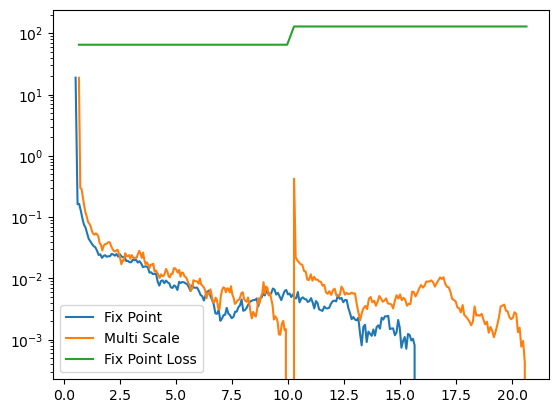

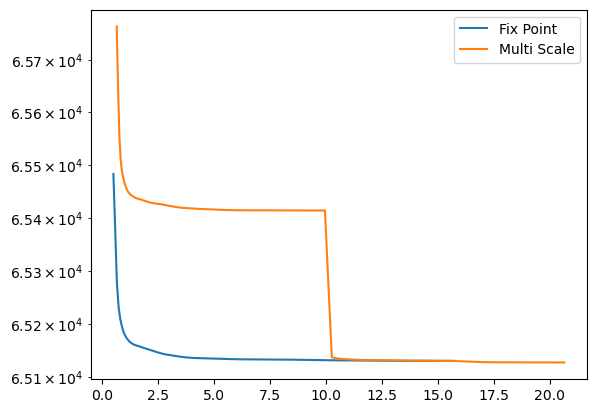

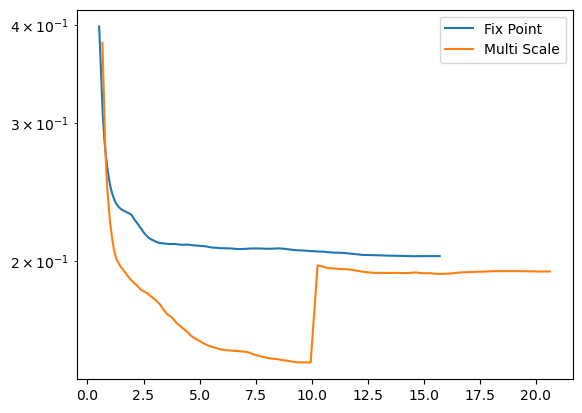

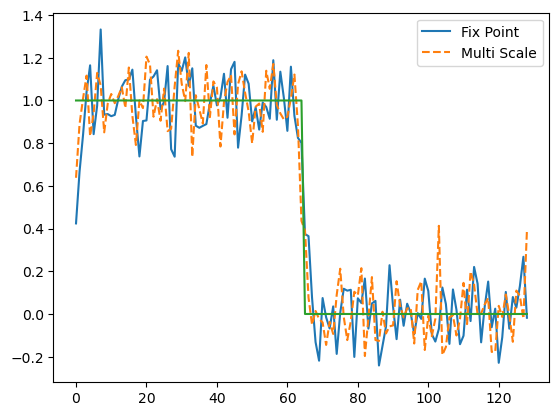

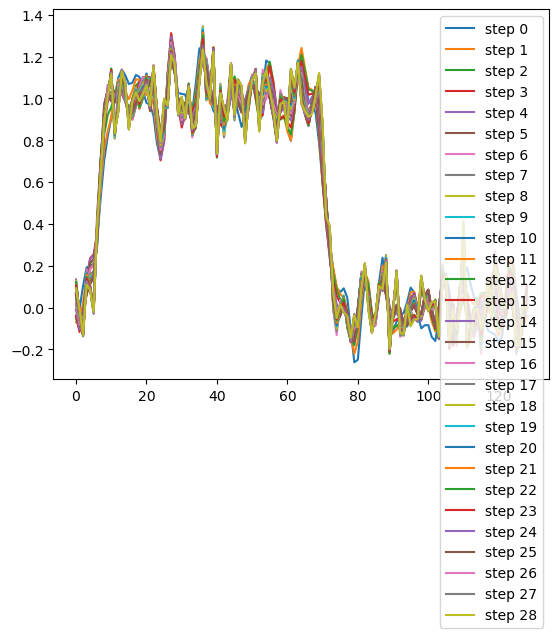

In [4]:
plt.semilogy(time_fp, res_fp, label="Fix Point")
plt.semilogy(time_ms, res_ms, label="Multi Scale")
plt.semilogy(time_ms, size_ms, label="Fix Point Loss")
plt.legend()


plt.figure()
plt.semilogy(time_fp, loss_fp, label="Fix Point")
plt.semilogy(time_ms, loss_ms, label="Multi Scale")
plt.legend()

plt.figure()
plt.semilogy(time_fp, error_fp, label="Fix Point")
plt.semilogy(time_ms, error_ms, label="Multi Scale")
plt.legend()

plt.figure()
plt.plot(align(fft(x), fft(x_fp), x_fp), label="Fix Point")
plt.plot(align(fft(x), fft(x_ms), x_ms), '--', label="Multi Scale")
plt.plot(x)
plt.legend()

plt.figure()
for i, xfft_ in enumerate(xfft_ms):
    xfft_ = resize(xfft_, yfft.shape[1])
    plt.plot(ifft(xfft_), label=f"step {i}")
    
plt.legend()

print(f"Relative Error: {error_ms[-1]}")

* How good are the shifts estimated?
* Implement correct upsampling Nyquist frequency
* power of 2 corresponds to every secondpoint, upscaling corresponds to zero + sinc
* Why does better initialisation not help?
* What parts of spectrum converge first? (spectral bias)
* Alignment weighs frequencies equally, but assume  $\sigma_i x = x_i$. Is there some optimal filter? Wiener filter $\hat x_j^2/(\hat x_j^2+\sigma^2)$
* It's all down to the curvature of the loss function, which is also the gradient of the aligning function.
  $$
    \lim_{||h||\to 0}\frac{\lim_{N\to \infty}\sum_{i=1}^N (\sigma_i(x+h)x_i - \sigma_i(x)x_i)}{||h||}
  $$